In [1]:
# Import Dataset From Kaggle To Google Colab

!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets list
!kaggle datasets download -d jangedoo/utkface-new
! unzip utkface-new.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: train/utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflati

In [13]:
!pip install wandb

In [14]:
#Import Libarary

import os
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [15]:
import wandb
from wandb.keras import(
   WandbMetricsLogger,
   WandbModelCheckpoint
)

In [16]:
run = wandb.init(project="new")
config = wandb.config
wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models.keras"),
]

In [17]:
#Prepare Dataset

images = []
ages = []

for img_name in os.listdir("/content/train/UTKFace"):
    age = img_name.split("_")[0]
    ages.append(int(age))

    image = cv.imread("/content/train/UTKFace/" + img_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image,(128,128))
    images.append(image)

In [18]:
# Convert Dataset to DataFrame

images = pd.Series(images,name="Images")
ages = pd.Series(ages, name="Ages")

df = pd.concat([images,ages],axis=1)
df.head()

,Images,Ages
0,"[[[76, 71, 65], [57, 52, 46], [44, 39, 34], [5...",55
1,"[[[7, 12, 11], [16, 21, 17], [41, 44, 40], [63...",1
2,"[[[145, 74, 42], [142, 71, 39], [150, 79, 47],...",44
3,"[[[123, 108, 77], [129, 115, 85], [127, 112, 8...",26
4,"[[[100, 80, 73], [92, 69, 63], [82, 56, 52], [...",29


In [19]:
del images
del ages

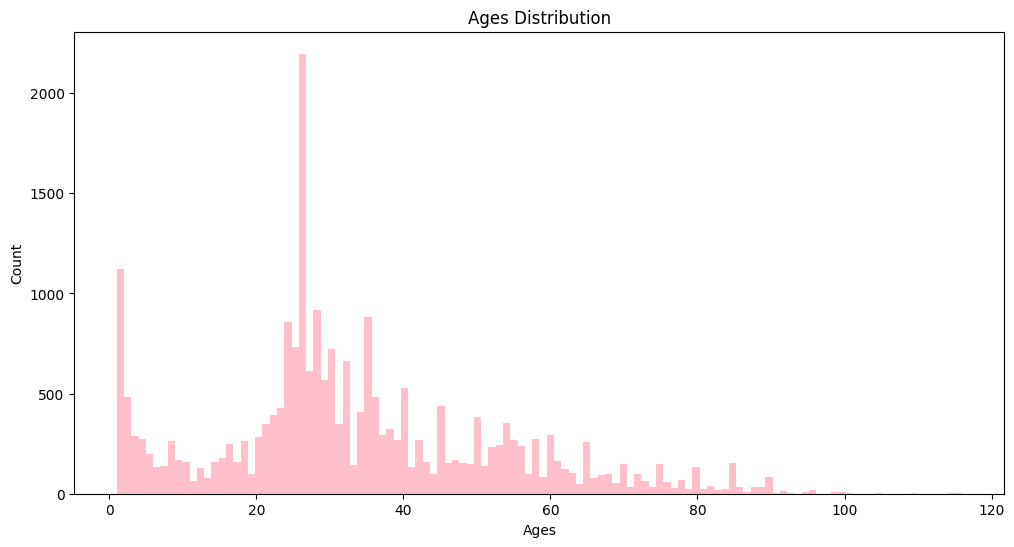

In [6]:
# Plot Histogram For Show Data

plt.figure(figsize=(12,6))
plt.hist(df["Ages"],bins=df["Ages"].max(),color="pink")
plt.title("Ages Distribution")
plt.xlabel("Ages")
plt.ylabel("Count")
plt.show()

In [20]:
# Clean Dataset For Training Model Better

df = df[df["Ages"] <= 80]

age_1 = df[df["Ages"] == 1].sample(frac=0.4, random_state=42)
age_2 = df[df["Ages"] == 26].sample(frac=0.4, random_state=42)

df = df[(df["Ages"] != 1) & (df["Ages"] != 26)]

df = pd.concat([df, age_1, age_2], ignore_index=True)

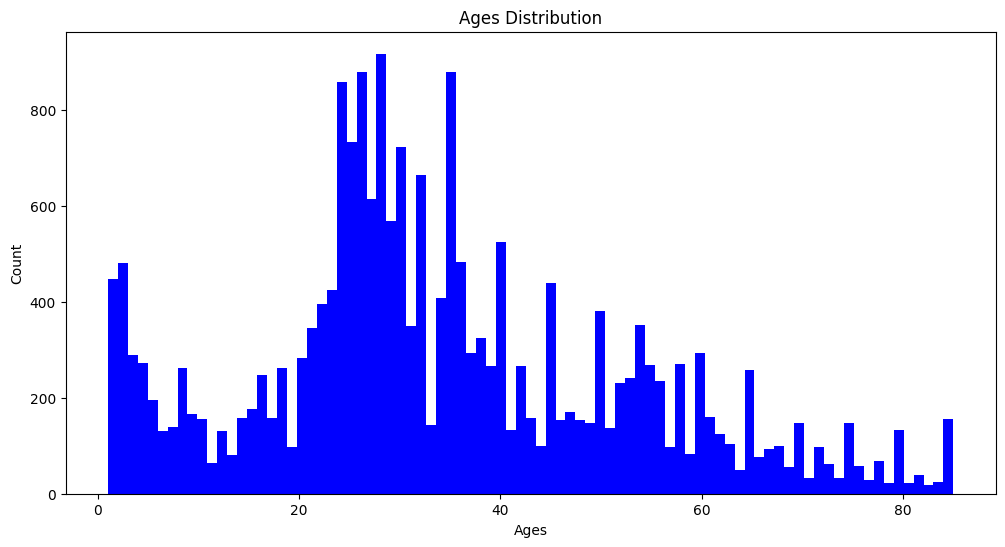

In [27]:
# Plot Histogram For Checking Dataset

plt.figure(figsize=(12,6))
plt.hist(df["Ages"],bins=df["Ages"].max(),color="blue")
plt.title("Ages Distribution")
plt.xlabel("Ages")
plt.ylabel("Count")
plt.show()

In [21]:
# Convert DataFrame To Numpy Array

X = np.array(df["Images"].values.tolist())
Y = np.array(df["Ages"].values.tolist())
print(X.shape)
print(Y.shape)

(21176, 128, 128, 3)
(21176,)


In [22]:
del df

In [23]:
# Split Dataset To Test And Train

X_train , X_validation , Y_train , Y_validation = train_test_split(X,Y,test_size=0.2)
Y_train = Y_train / 80.0
Y_validation = Y_validation / 80.0


print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(16940, 128, 128, 3)
(4236, 128, 128, 3)
(16940,)
(4236,)


In [24]:
del X
del Y

In [25]:
# Data Augmentation

image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0,
    horizontal_flip=True
)

dataset_train = image_data_generator.flow(
    X_train,
    Y_train,
    batch_size=16
)

dataset_validation = image_data_generator.flow(
    X_validation,
    Y_validation,
    batch_size=16
)

In [26]:
del X_train
del X_validation
del Y_train
del Y_validation

In [27]:
# Transfer Learning

my_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling="avg"

)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [30]:
# Add My new layer


model = tf.keras.Sequential([
    my_model,
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1,activation="relu")
])

model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)


In [31]:
history = model.fit(dataset_train, epochs=5, validation_data=dataset_validation, callbacks=wandb_callbacks)

Epoch 1/5
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 212s 146ms/step - loss: 0.4184 - val_loss: 0.4172
Epoch 2/5
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 170s 136ms/step - loss: 0.4195 - val_loss: 0.4172
Epoch 3/5
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 141s 133ms/step - loss: 0.3754 - val_loss: 0.1764
Epoch 4/5
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 135s 128ms/step - loss: 0.1948 - val_loss: 0.1809
Epoch 5/5
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 135s 127ms/step - loss: 0.1979 - val_loss: 0.1952


In [32]:
model.save("model.h5")

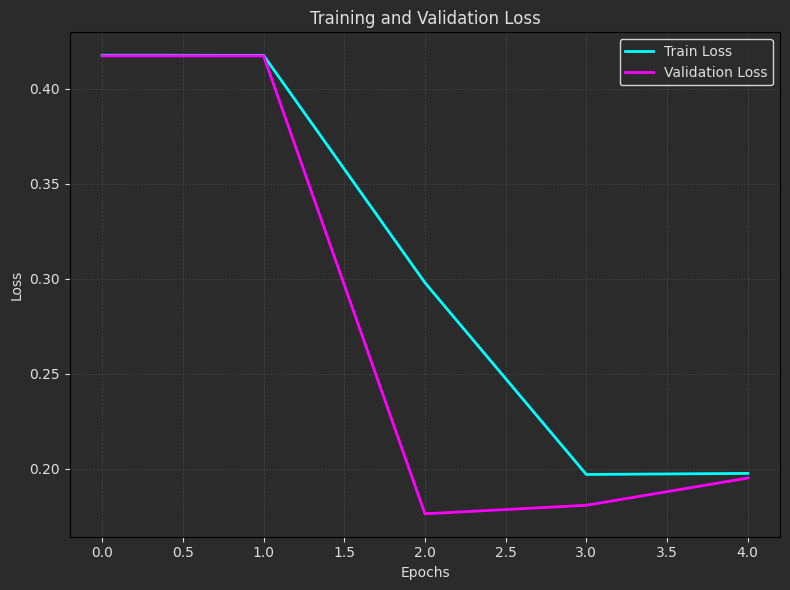

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#2b2b2b')

ax.plot(history.history['loss'], label='Train Loss', color='cyan', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation Loss', color='magenta', linewidth=2)

ax.set_title('Training and Validation Loss', color='#e0e0e0')
ax.set_xlabel('Epochs', color='#e0e0e0')
ax.set_ylabel('Loss', color='#e0e0e0')
ax.tick_params(colors='#e0e0e0')
ax.grid(color='#555555', linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_facecolor('#2b2b2b')
ax.legend(facecolor='#2b2b2b', edgecolor='white', labelcolor='#e0e0e0')

plt.tight_layout()



In [34]:
from tensorflow.keras.models import load_model

model = load_model("model.h5")


def preprocess_image(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (128, 128))


    image = image / 255.0
    image = tf.image.flip_left_right(image)


    image = np.expand_dims(image, axis=0)
    return image

def predict_age(image_path):
    processed_image = preprocess_image(image_path)
    predicted_age = model.predict(processed_image) * 80.0
    return predicted_age[0][0]


image_path = "/content/photo_6024045821869278289_y.jpg"
predicted_age = predict_age(image_path)
print(f"Predicted Age: {predicted_age:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Age: 30.54
